In [1]:
%load_ext autoreload
%autoreload 2

import os,sys,inspect
# current_dir = '/home/jiayuand/seqOED_variational/examples/location'
# parent_dir = '/home/jiayuand/seqOED_variational'

# current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
# parent_dir = os.path.dirname(os.path.dirname(current_dir))
parent_dir = '../../'
sys.path.insert(0, parent_dir) 

import numpy as np
# from scipy.stats import norm, beta, dirichlet
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from   torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
if torch.cuda.is_available():  
    dev = "cuda" 
else:  
    dev = "cpu"  
device = torch.device(dev) 
torch.set_default_device(device)
dtype = torch.float32
torch.set_default_dtype(dtype)

from vsOED import VSOED, PGvsOED, GMM_NET, NFs, POST_APPROX
from vsOED.utils import *
from vsOED.models import *

import dowel
import joblib

print('==============================================================================')
print('Please go to /home/<USER>/.local/lib/python3.9/site-packages/torch/storage.py')
print('and change def _load_from_bytes(b):')
print('to')
print(f'    return torch.load(io.BytesIO(b), map_location="{dev}")')
print('==============================================================================')

Please go to /home/<USER>/.local/lib/python3.9/site-packages/torch/storage.py
and change def _load_from_bytes(b):
to
    return torch.load(io.BytesIO(b), map_location="cpu")


In [90]:
data_folder = parent_dir + './results/ces/'
subfolders = {'rl': data_folder + 'RL_BOED/',
              'gmm': data_folder + 'GMM/',
              'nfs': data_folder + 'NFs/'}

In [91]:
# read in rl-boed results
rl_rwds = {}
rl_full_rwds = {}
rl_full_rwds['terminal'] = np.load(subfolders['rl'] + '/ces_full_terminal_res.npy')
rl_full_rwds['terminal'] = np.moveaxis(rl_full_rwds['terminal'], -1, 0)
rl_full_rwds['incre'] = np.load(subfolders['rl'] + '/ces_full_incre_res.npy')
rl_full_rwds['incre'] = np.moveaxis(rl_full_rwds['incre'], -1, 0)
rl_rwds['terminal'] = np.load(subfolders['rl'] + '/ces_terminal_res.npy')
rl_rwds['terminal'] = np.moveaxis(rl_rwds['terminal'], -1, 0)
rl_rwds['incre'] = np.load(subfolders['rl'] + '/ces_incre_res.npy')
rl_rwds['incre'] = np.moveaxis(rl_rwds['incre'], -1, 0)

In [92]:
# read in gmm results
hs = list(range(1, 11))
gmm_rwds = {}
for mode in ('terminal', 'incre'):
    gmm_rwds[mode] = np.full((4, 2000, 10, 11), np.nan)
    for id in range(4):
        for k, h in enumerate(hs):
            try:
                res = torch.load(subfolders['gmm'] + f'/{mode}_id{id}_h{h}/evaluation.pt', map_location=device)
                gmm_rwds[mode][id, :, k, :h+1] = res['rewards_hist'].numpy()
            except:
                pass
        

/tmp/ipykernel_2190917/1183806163.py:5: RuntimeWarning: Mean of empty slice
  rwds = np.nancumsum(np.nanmean(gmm_rwds[mode][:, :, -1, :], axis=(0, 1)), axis=-1)[:-1]


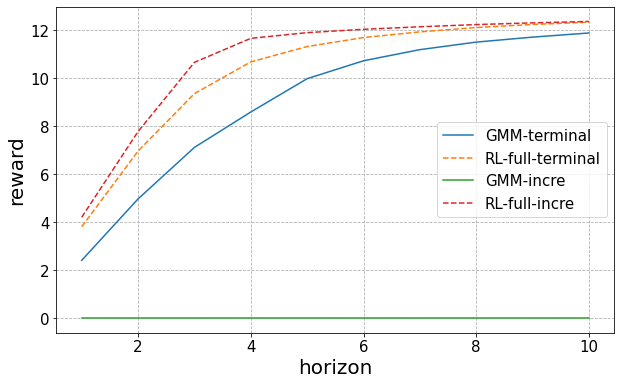

In [93]:
# draw evaluation of T=10, compared with fully trained
plt.figure(figsize=(10, 6))
stages = np.arange(1, 11)
for mode in ['terminal', 'incre']:
    rwds = np.nancumsum(np.nanmean(gmm_rwds[mode][:, :, -1, :], axis=(0, 1)), axis=-1)[:-1]
    plt.plot(stages, rwds, label=f'GMM-{mode}')
    plt.plot(stages, rl_full_rwds[mode].mean(axis=(0, 1)), label=f'RL-full-{mode}', ls='--')

plt.legend(fontsize=15)
plt.xlabel('horizon', fontsize=20)
plt.ylabel('reward', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(ls='--')

/tmp/ipykernel_2190917/3787897409.py:5: RuntimeWarning: Mean of empty slice
  rwds = np.nansum(np.nanmean(gmm_rwds[mode], axis=(0, 1)), axis=1)
/tmp/ipykernel_2190917/3787897409.py:5: RuntimeWarning: Mean of empty slice
  rwds = np.nansum(np.nanmean(gmm_rwds[mode], axis=(0, 1)), axis=1)


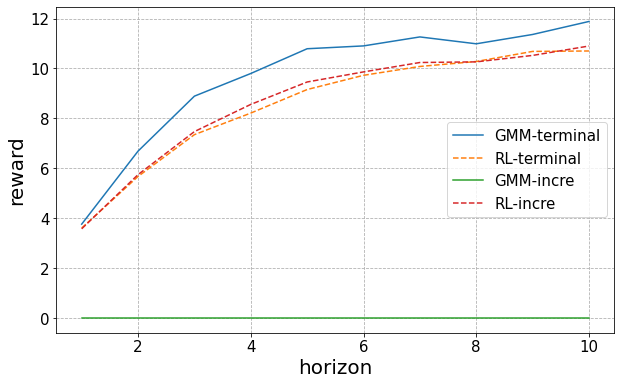

In [94]:
# draw evaluation of each T, compared with limited training
plt.figure(figsize=(10, 6))
stages = np.arange(1, 11)
for mode in ['terminal', 'incre']:
    rwds = np.nansum(np.nanmean(gmm_rwds[mode], axis=(0, 1)), axis=1)
    plt.plot(hs, rwds, label=f'GMM-{mode}')
    plt.plot(stages, rl_rwds[mode].mean(axis=(0, 1)), label=f'RL-{mode}', ls='--')
plt.legend(fontsize=15)
plt.xlabel('horizon', fontsize=20)
plt.ylabel('reward', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(ls='--')

In [95]:
# pick a mode , id and horizon, and load the data
post_net_type = 'gmm'
mode = 'terminal'
id = 0
h = 10
subfolder = subfolders[post_net_type] + f'/{mode}_id{id}_h{h}/'
eval_data = torch.load(subfolder + 'evaluation.pt', map_location=device)
params = eval_data['params']
ds_hist = eval_data['ds_hist']
ys_hist = eval_data['ys_hist']
rewards_hist = eval_data['rewards_hist']
vsoed = joblib.load(subfolder + f'/itr_10000.pkl')

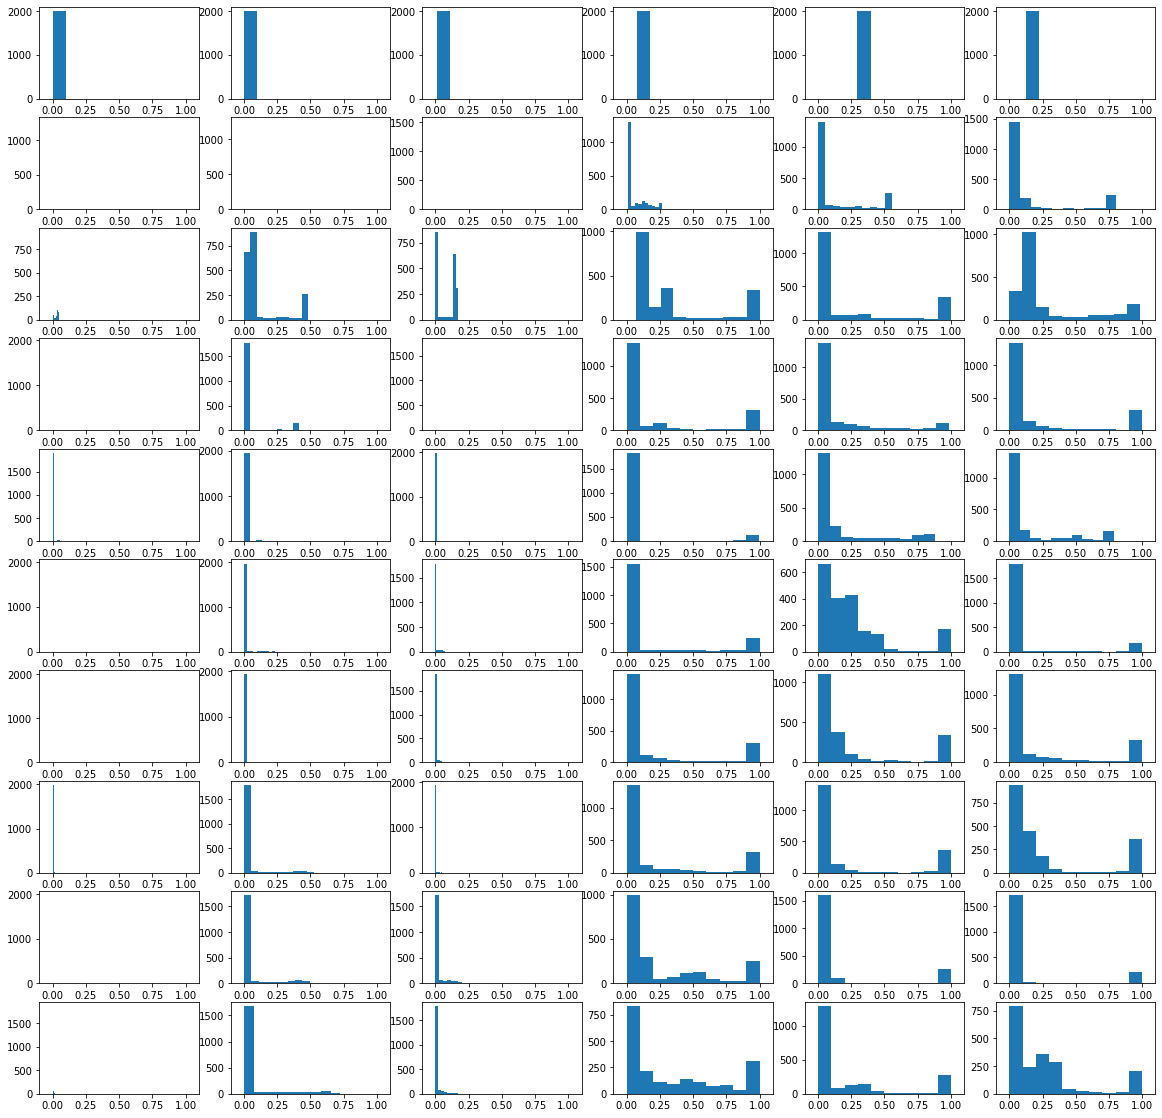

In [96]:
# draw designs
plt.figure(figsize=(20, 20))
for stage in range(h):
    for i in range(6):
        plt.subplot(h, 6, stage * 6 + i + 1)
        plt.hist(ds_hist[:, stage, i].cpu().numpy(), )
        plt.xlim(-0.1, 1.1)

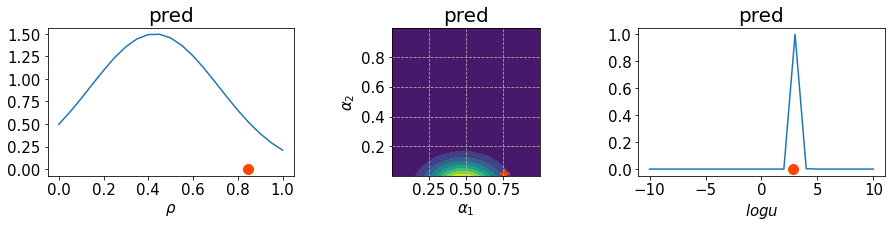

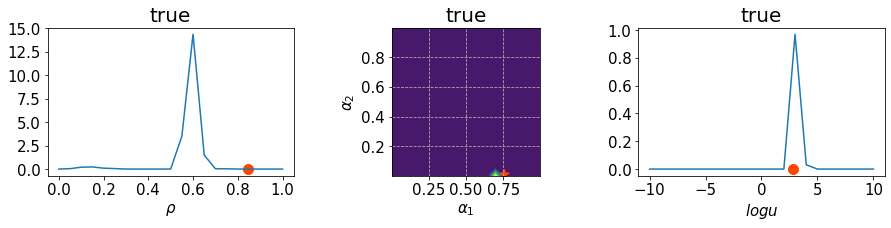

In [170]:
# randomly pick 1 index of samples, and draw the posterior
# np.random.seed(213)
idx = np.random.choice(len(params), 1, replace=False)[0]
# idx = 20
param_bounds =  [[0.0001, 0.9999]] * 3 + [[-10, 10]]
n_grid = 21
param_grids = [np.linspace(param_bounds[i][0], param_bounds[i][1], n_grid) for i in range(len(param_bounds))]
PARAM = np.meshgrid(*param_grids, indexing='ij')
PARAM = np.array(PARAM)
PARAM = np.moveaxis(PARAM, 0, -1)
PARAM_tensor = torch.from_numpy(np.array(PARAM)).view(-1, len(param_bounds)).float()
net = vsoed.post_approx.poi_post_nets[h - 1][0]

param = params[idx].numpy()
d_hist = ds_hist[idx].numpy()
y_hist = ys_hist[idx].numpy()

X = vsoed.post_approx.form_input(h, ds_hist[idx:idx+1], ys_hist[idx:idx+1])
X = X.expand(len(PARAM_tensor), -1)
with torch.no_grad():
    logpost_pred = net(X, PARAM_tensor)
post_pred = torch.exp(logpost_pred).reshape([n_grid]*len(param_bounds))
post_pred = post_pred.cpu().numpy()

plt.figure(figsize=(15, 6))
plt.subplot(2, 3, 1)
post = post_pred.sum(axis=(-3, -2, -1))
post /= post.sum() * (param_grids[0][1] - param_grids[0][0])
plt.plot(param_grids[0], post)
plt.scatter(param[0], 0, s=100, c='orangered')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('$\\rho$', fontsize=15)
plt.title('pred', fontsize=20)

plt.subplot(2, 3, 2, aspect='equal')
XY = PARAM[0, :, :, 0, 1:3]
X = XY[:, :, 0]
Y = XY[:, :, 1]
post = post_pred.sum(axis=(0, -1))
plt.contourf(X, Y, post)
plt.scatter(param[1], param[2], s=100, c='orangered', marker='*')
plt.title('pred', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('$\\alpha_1$', fontsize=15)
plt.ylabel('$\\alpha_2$', fontsize=15)
plt.grid(ls='--')

plt.subplot(2, 3, 3)
post = post_pred.sum(axis=(0, 1, 2))
post /= post.sum() * (param_grids[-1][1] - param_grids[-1][0])
plt.plot(param_grids[-1], post)
plt.scatter(param[-1], 0, s=100, c='orangered')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('$logu$', fontsize=15)
plt.title('pred', fontsize=20)

logprior_true = vsoed.prior.log_poi_prior(PARAM_tensor)
loglikeli_true = 0
for stage in range(h):
    loglikeli_true += vsoed.loglikeli(h, ys_hist[idx][stage:stage+1], PARAM_tensor, ds_hist[idx][stage:stage+1])
logpost_true = logprior_true + loglikeli_true
post_true = torch.exp(logpost_true).reshape([n_grid]*len(param_bounds))

plt.figure(figsize=(15, 6))
plt.subplot(2, 3, 4)
post = post_true.sum(axis=(-3, -2, -1))
post /= post.sum() * (param_grids[0][1] - param_grids[0][0])
plt.plot(param_grids[0], post)
plt.scatter(param[0], 0, s=100, c='orangered')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('$\\rho$', fontsize=15)
plt.title('true', fontsize=20)

plt.subplot(2, 3, 5, aspect='equal')
XY = PARAM[0, :, :, 0, 1:3]
X = XY[:, :, 0]
Y = XY[:, :, 1]
post = post_true.sum(axis=(0, -1))
plt.contourf(X, Y, post)
plt.scatter(param[1], param[2], s=100, c='orangered', marker='*')
plt.title('true', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('$\\alpha_1$', fontsize=15)
plt.ylabel('$\\alpha_2$', fontsize=15)
plt.grid(ls='--')

plt.subplot(2, 3, 6)
post = post_true.sum(axis=(0, 1, 2))
post /= post.sum() * (param_grids[-1][1] - param_grids[-1][0])
plt.plot(param_grids[-1], post)
plt.scatter(param[-1], 0, s=100, c='orangered')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('$logu$', fontsize=15)
plt.title('true', fontsize=20)

plt.show()

In [171]:
y_hist

array([[-1.00000000e+00],
       [-6.99881375e-01],
       [-1.00000000e+00],
       [ 3.42730016e-01],
       [ 6.04588129e-02],
       [ 2.19117617e-04],
       [ 1.41093254e-01],
       [ 1.00000000e+00],
       [ 1.55952815e-02],
       [ 3.06198420e-03]], dtype=float32)

(array([3798.,  125.,  157.,  174.,  220.,  233.,  286.,  351.,  372.,
         416.,  524.,  563.,  487.,  405.,  425.,  493.,  545.,  610.,
         649.,  734.,  800.,  836., 1051., 1263., 2084.,  617.,  199.,
         124.,   90.,   72.,   56.,   57.,   37.,   41.,   23.,   29.,
          16.,   20.,   26.,   20.,   15.,   25.,   17.,   13.,   19.,
          13.,   12.,   11.,   12.,  835.]),
 array([-1.  , -0.96, -0.92, -0.88, -0.84, -0.8 , -0.76, -0.72, -0.68,
        -0.64, -0.6 , -0.56, -0.52, -0.48, -0.44, -0.4 , -0.36, -0.32,
        -0.28, -0.24, -0.2 , -0.16, -0.12, -0.08, -0.04,  0.  ,  0.04,
         0.08,  0.12,  0.16,  0.2 ,  0.24,  0.28,  0.32,  0.36,  0.4 ,
         0.44,  0.48,  0.52,  0.56,  0.6 ,  0.64,  0.68,  0.72,  0.76,
         0.8 ,  0.84,  0.88,  0.92,  0.96,  1.  ], dtype=float32),
 <BarContainer object of 50 artists>)

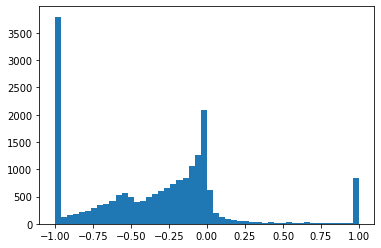

In [174]:
plt.hist(ys_hist.numpy().flatten(), bins=50)

In [147]:
np.where(post_pred == post_pred.max())

(array([15]), array([9]), array([4]), array([13]))

In [148]:
np.where(post_true == post_true.max())

(array([6]), array([7]), array([6]), array([14]))

In [150]:
torch.argsort(params[:, 0])

tensor([1594,  305, 1506,  ..., 1687, 1238, 1568])

In [155]:
params[1568]

tensor([ 0.9995,  0.1960,  0.7682, -1.0260])

In [156]:
ys_hist[1568]

tensor([[-0.5780],
        [-0.1400],
        [-0.6121],
        [-0.4481],
        [-0.1327],
        [-0.4924],
        [-0.5459],
        [-0.4407],
        [-0.5087],
        [-1.0000]])

In [157]:
ys_hist[1594]

tensor([[-1.0000],
        [-0.0604],
        [-0.7466],
        [ 0.0072],
        [-0.0047],
        [-0.1149],
        [-0.5950],
        [-0.0996],
        [-0.1428],
        [-1.0000]])

(array([208., 195., 181., 231., 190., 225., 193., 203., 203., 171.]),
 array([2.7750205e-04, 1.0019606e-01, 2.0011462e-01, 3.0003318e-01,
        3.9995176e-01, 4.9987033e-01, 5.9978890e-01, 6.9970745e-01,
        7.9962599e-01, 8.9954460e-01, 9.9946314e-01], dtype=float32),
 <BarContainer object of 10 artists>)

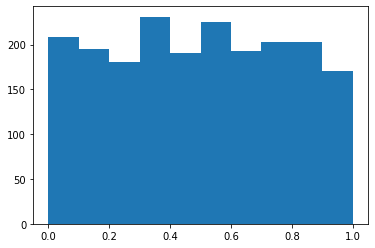

In [121]:
plt.hist(params[:, 0].numpy())